# VGG16: Image Classification

El código ha sido extraído de la guía de uso de las SHAP values, elaborada por el creador de la librería Scott Lundberg. Se puede acceder a la misma a través de la siguiente url:

https://shap.readthedocs.io/en/latest/index.html

In [1]:
#Importamos librerías
import keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import requests
from skimage.segmentation import slic
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import shap

### 1. Carga del modelo y segmentación de la imagen.

(-0.5, 223.5, 223.5, -0.5)

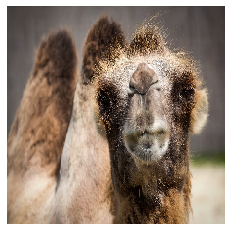

In [9]:
#Cargamos el modelo y las etiquetas de dataset ImageNet
model = VGG16()
r = requests.get('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')
#Nombre de las etiquetas
feature_names = r.json()


#Cargamos la imagen que queremos clasificar
file = "vggimages/camel.jpg"
#Tamaño, cuadrado
img = image.load_img(file, target_size=(224, 224))
#Convertimos la imagen a array
img_orig = image.img_to_array(img)
#Mostramos la imagen
plt.imshow(img)
plt.axis('off')

(-0.5, 223.5, 223.5, -0.5)

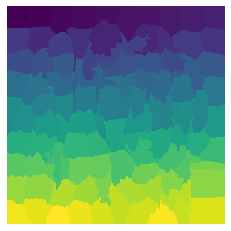

In [10]:
#Segmentamos la imagen para que el modelo no tenga que explicar todos los píxels
segments_slic = slic(img, n_segments=100, compactness=20, sigma=1)
#Mostramos la imagen segmentada
plt.imshow(segments_slic)
plt.axis('off')

### 2. Predicción de la clasificación.

In [11]:
#Definimos una función que dependa de una máscara binaria
#que represente si una región de la imagen está oculta
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    #Creamos un array 4D vacío
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out
#Definimos una función que prediga la clasificación de la imagen 
def f(z):
    return model.predict(preprocess_input(mask_image(z, segments_slic, img_orig, 255)))

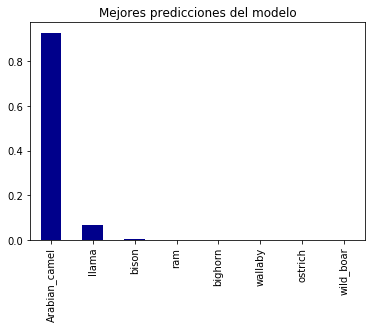

In [12]:
#Extraemos las predicciones más valoradas del modelo
preds = model.predict(preprocess_input(np.expand_dims(img_orig.copy(), axis=0)))
top_preds = np.argsort(-preds)
inds = top_preds[0]
top_8_pred=pd.Series(data={feature_names[str(inds[i])][1]:preds[0, inds[i]] for i in range(8)})
top_8_pred.plot(kind='bar', title='Mejores predicciones del modelo',
                color = 'darkblue')

### 3. Aplicación SHAP values

In [13]:
#Usamos el KernelExplainer para explicar las predicciones de la red
#Mediante el cálculo del explainer y las SHAP values.
explainer = shap.KernelExplainer(f, np.zeros((1,50)))
#Corremos VGG 1000 veces
shap_values = explainer.shap_values(np.ones((1,50)), nsamples=1000)

### 4. Visualización de los resultados.

In [14]:
#Creamos un mapa de color
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
cm = LinearSegmentedColormap.from_list("shap", colors)

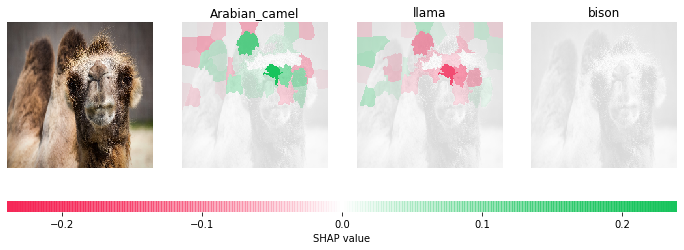

In [15]:
#Definimos una función con la que colorear las distintas partes de la imagen segmentada
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

#Graficamos nuestras explicaciones
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
#Representamos las predicciones más valoradas
inds = top_preds[0]
#Imagen original
axes[0].imshow(img)
axes[0].axis('off')
#Cogemos el valor máximo de las SHAP values
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
#Representamos las tres mejores predicciones
for i in range(3):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    axes[i+1].set_title(feature_names[str(inds[i])][1])
    axes[i+1].imshow(img.convert('LA'), alpha=0.15)
    #Escala de color
    im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()